In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [397]:
df = pd.read_csv('/workspaces/ml-zoomcamp-hw/04-Evaluation Metrics for Classification/course_lead_scoring.csv')

In [398]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [399]:
df.dtypes
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income','interaction_count','lead_score']

In [400]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [401]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [402]:

df_full_train, df_test = train_test_split(df, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1 )
df_train.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [403]:
auc_score = {}
y = df_train['converted']
for n in numerical:
    auc_value = roc_auc_score(y, df_train[n])
    
    auc_score[n] = auc_value


auc_score    

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [404]:
dv = DictVectorizer()
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = df_train.converted.values
y_val = df_val.converted.values



model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

converted_decision = (y_pred >= 0.5)
(y_val == converted_decision).mean()

np.float64(0.6996587030716723)

In [405]:
auc = roc_auc_score(y_val, y_pred)
auc



0.8171316268814112

Recall = TP/TP+FN
Recall is the same as TPR
Of all the actual positives, how many did we correctly identify? 

Precision = TP/ TP + FP   
Of all the predicted positives, how many were actually positive?


In [406]:
actual_postive = (y_val == 1)
actual_negative = (y_val ==0)

In [407]:
t = 0.5
predict_positive = (y_pred >=t)
predict_negative = (y_pred < t)

In [408]:
tp = (predict_positive & actual_postive).sum()
fp = (predict_positive & actual_negative).sum()

tn = (predict_negative & actual_negative).sum()
fn = (predict_negative & actual_postive).sum()

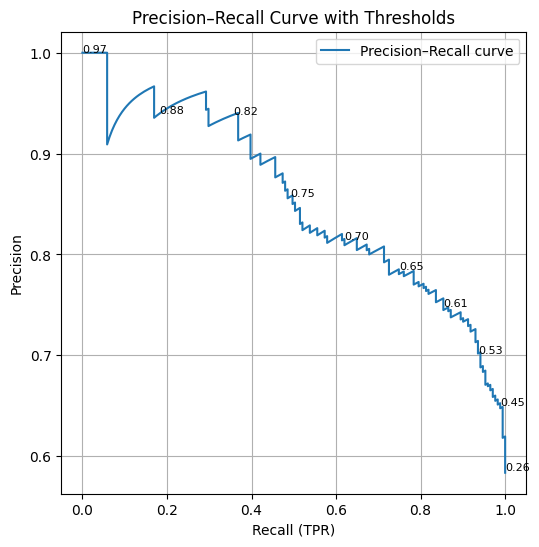

In [409]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label='Precision–Recall curve')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve with Thresholds')
plt.grid(True)

# thresholds has length len(precision)-1; align labels at recall[1:], precision[1:]
idxs = np.linspace(0, len(thresholds)-1, num=min(10, len(thresholds))).astype(int)
for i in idxs:
    plt.text(recall[i+1], precision[i+1], f'{thresholds[i]:.2f}', fontsize=8)

plt.legend()
plt.show()

In [410]:
diff = np.abs(precision[:-1] - recall[:-1])
best_idx = diff.argmin()


best_threshold = thresholds[best_idx]
round(best_threshold, 3)

np.float64(0.644)

In [411]:
diff[best_idx]

np.float64(0.0)

In [412]:
from sklearn.metrics import f1_score

f1_thresholds = np.linspace(0, 1, 101)

best_f1 = 0
best_thr = 0

for t in f1_thresholds:
    y_pred_bin =(y_pred >= t).astype(int)
    score = f1_score(y_val, y_pred_bin)
    
    if score > best_f1:
        best_f1 = score
        best_thr = t
        
        
best_f1, best_thr


(0.8125, np.float64(0.5700000000000001))

In [413]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores =  []

for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx].copy()
    df_val   = df_full_train.iloc[val_idx].copy()

    y_train = df_train['converted'].values
    y_val   = df_val['converted'].values

    
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    val_dicts   = df_val[categorical + numerical].to_dict(orient='records')

  
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val   = dv.transform(val_dicts)

    model.fit(X_train, y_train)

    # Predict & score
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

auc_scores = np.array(auc_scores)
std_auc = auc_scores.std()
std_auc

np.float64(0.03580711942905165)

In [414]:
c = [0.000001, 0.001, 1]

results = {}

for c in c:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    
    auc_scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx].copy()
        df_val   = df_full_train.iloc[val_idx].copy()

        y_train = df_train['converted'].values
        y_val   = df_val['converted'].values

        
        train_dicts = df_train[categorical + numerical].to_dict(orient='records')
        val_dicts   = df_val[categorical + numerical].to_dict(orient='records')

    
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val   = dv.transform(val_dicts)

        model.fit(X_train, y_train)

        # Predict & score
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    results[c] = {
        'mean_auc': round(np.mean(auc_scores),3),
        'std_auc': round(np.std(auc_scores),3)
    }


for c, vals in results.items():
    print(f"C={c}: mean AUC={vals['mean_auc']:.4f}, std={vals['std_auc']:.4f}")
    
best_C = max(results, key=lambda k: results[k]['mean_auc'])
print(f"\nBest C value: {best_C}")

C=1e-06: mean AUC=0.5600, std=0.0240
C=0.001: mean AUC=0.8670, std=0.0290
C=1: mean AUC=0.8220, std=0.0360

Best C value: 0.001
